# Linear response


We will calculate the optical absorption in the random phase approximation (RPA) and compare it to time-domain simulations in the linear response regime, subject to a weak external field. Note, however, that the time-domain simulaton is not limited to the linear-response case, as demonstrated in [Cox et al.](https://www.nature.com/articles/ncomms6725).

## RPA

First, we set up the RPA simulation. We will consider a triangular nanoflake

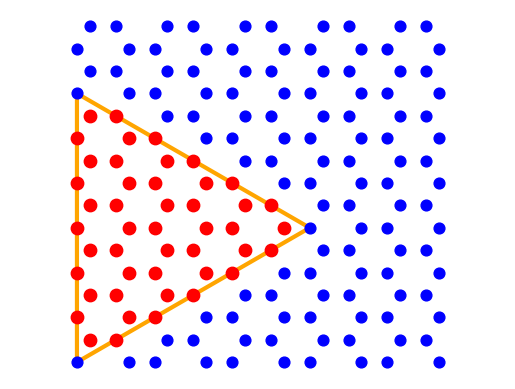

In [1]:
import jax.numpy as jnp
from granad import MaterialCatalog, Triangle

# get material
graphene = MaterialCatalog.get( "graphene" )

# cut a 15 Angström wide triangle from the lattice (can also be an arbitrary polygon)
flake = graphene.cut_flake( Triangle(15), plot = True  ) 

# frequencies
omegas_rpa = jnp.linspace( 0, 6, 40 )

We obtain the polarizability for a uniform external field according to 

$$\alpha_{ij}(\omega) = x_j \chi_0(\omega)/ (1- C \chi_0(\omega)) x_i$$

where $\chi_0(\omega)$ is the bare density-density correlator and $C$ is the Coulomb matrix, as in [Thongrattanasiri et al.](https://pubs.acs.org/doi/10.1021/nn204780e)

Here, we focus on an external x-polarized field

In [2]:
polarizability = flake.get_polarizability_rpa(
    omegas_rpa,
    relaxation_rate = 1/10,
    polarization = 0, 
    hungry = 2 )

From the imaginary part of the polarizability, we obtain the absorption spectrum as follows

In [3]:
absorption_rpa = jnp.abs( polarizability.imag * 4 * jnp.pi * omegas_rpa )

## Time-domain simulations

For the time-domain simulations, we specify a spectrally broad external illumination (i.e. a narrow pulse in time domain) to capture the system's response over a large frequency range.

In [4]:
from granad import Pulse
pulse = Pulse(
    amplitudes=[1e-5, 0, 0], frequency=2.3, peak=5, fwhm=2
)

We then compute the time-dependent dipole moment and Fourier transform it.

In [5]:
result = flake.master_equation(
    expectation_values = [ flake.dipole_operator ],
    end_time=40,
    relaxation_rate=1/10,
    illumination=pulse,
)

RHS compiled
RHS compiled


100.0 %


The polarizability tensor is given by $\alpha_{ij} = p_i / E_j$. Here, we investigate the xx-component.

In [6]:
omega_max = omegas_rpa.max()
omega_min = omegas_rpa.min()
p_omega = result.ft_output( omega_max, omega_min )[0]
omegas_td, pulse_omega = result.ft_illumination( omega_max, omega_min )
absorption_td = jnp.abs( -omegas_td * jnp.imag( p_omega[:,0] / pulse_omega[:,0] ) )

We can now compare the two results.

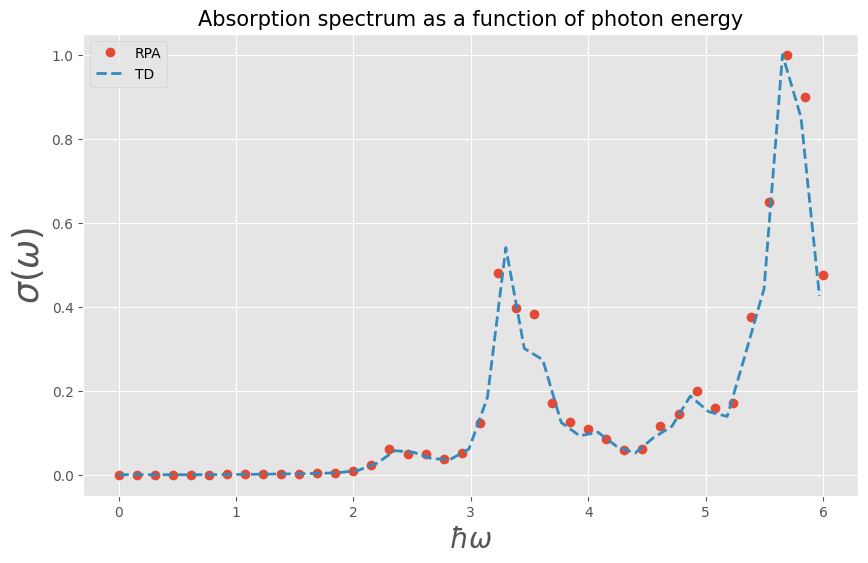

In [7]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
plt.plot(omegas_rpa, absorption_rpa / jnp.max(absorption_rpa), 'o', linewidth=2, label = 'RPA')
plt.plot(omegas_td, absorption_td / jnp.max(absorption_td), linewidth=2, ls = '--', label = 'TD' ) 
plt.xlabel(r'$\hbar\omega$', fontsize=20)
plt.ylabel(r'$\sigma(\omega)$', fontsize=25)
plt.title('Absorption spectrum as a function of photon energy', fontsize=15)
plt.legend()
plt.grid(True)
plt.show()